# Imaging Weights

This notebook will demonstrate how to create images with different imaging weighting schemes (natural, uniform, briggs) and how to make use of the ```storage_parms``` to append images.

For this demonstration data from the ALMA First Look at Imaging CASAguide (https://casaguides.nrao.edu/index.php/First_Look_at_Imaging) will be used. The measurement set has been converted to vis.zarr (using convert_ms in cngi.conversion)


## Installation and Dataset Download


In [ ]:
import os
os.system("pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.0.58rc2")

#https://drive.google.com/file/d/1O5Z0hbNUSFAnWGsXD6cxu3zMMuBYe9sg/view?usp=sharing
id = '1O5Z0hbNUSFAnWGsXD6cxu3zMMuBYe9sg'
os.system('curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=%s"' % id)
os.system('curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk \'/download/ {print $NF}\' ./cookie`&id=%s" -o ms.tar.gz' % id)
os.system('tar -xzf ms.tar.gz')
print('complete')

complete


## Load Dataset

For an explanation of how the vis.zarr file was created and the chunking go to the [continuum image example](https://cngi-prototype.io/en/latest/prototypes/continuum_imaging_example.html).

In [ ]:
import xarray as xr
from cngi.dio import read_vis

xr.set_options(display_style="html")

vis_dataset = read_vis("sis14_twhya_field_5_lsrk_pol_xx.vis.zarr", 0)
vis_dataset

<xarray.Dataset>
Dimensions:         (baseline: 210, chan: 384, pair: 2, pol: 1, receptor: 2, spw: 1, time: 270, uvw_index: 3)
Coordinates:
    antennas        (baseline, pair) int32 dask.array<chunksize=(210, 2), meta=np.ndarray>
  * baseline        (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan            (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11 3.728e+11
    chan_width      (chan) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    corr_product    (receptor, pol) int32 dask.array<chunksize=(2, 1), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    field           (time) <U6 dask.array<chunksize=(270,), meta=np.ndarray>
    interval        (time) float64 dask.array<chunksize=(270,), meta=np.ndarray>
    observation     (time) <U22 dask.array<chunksize=(270,), meta=np.ndarray>
  * pol             (pol) int32 9
    processor       (time) <U14 dask.array<chunksize=(270,), meta=np.ndarray>
    resolution      (chan) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    scan            (time) int32 dask.array<chunksize=(270,), meta=np.ndarray>
  * spw             (spw) int32 0
    state           (time) <U82 dask.array<chunksize=(270,), meta=np.ndarray>
  * time            (time) datetime64[ns] 2012-11-19T07:56:26.544000626 ... 2012-11-19T09:07:28.607999802
  * uvw_index       (uvw_index) <U2 'uu' 'vv' 'ww'
Dimensions without coordinates: pair, receptor
Data variables:
    ARRAY_ID        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    DATA            (time, baseline, chan, pol) complex128 dask.array<chunksize=(270, 210, 12, 1), meta=np.ndarray>
    EXPOSURE        (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED1           (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED2           (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FLAG            (time, baseline, chan, pol) bool dask.array<chunksize=(270, 210, 12, 1), meta=np.ndarray>
    FLAG_ROW        (time, baseline) bool dask.array<chunksize=(270, 210), meta=np.ndarray>
    IMAGING_WEIGHT  (time, baseline, chan, pol) float64 dask.array<chunksize=(270, 210, 12, 1), meta=np.ndarray>
    SIGMA           (time, baseline, pol) float64 dask.array<chunksize=(270, 210, 1), meta=np.ndarray>
    TIME_CENTROID   (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    UVW             (time, baseline, uvw_index) float64 dask.array<chunksize=(270, 210, 3), meta=np.ndarray>
    WEIGHT          (time, baseline, pol) float64 dask.array<chunksize=(270, 210, 1), meta=np.ndarray>
Attributes:
    assoc_spw_id:               []
    auto_correlations:          0
    bbc_no:                     2
    ddi:                        0
    freq_group:                 0
    freq_group_name:            
    if_conv_chain:              0
    make_imaging_weights_time:  1.7957208156585693
    meas_freq_ref:              1
    name:                       ALMA_RB_07#BB_2#SW-01#FULL_RES
    net_sideband:               2
    num_chan:                   384
    ref_frequency:              372520022603.63745
    total_bandwidth:            234366781.0546875

## Storage Parameters
All of the ngcasa.synthesis.imaging functions requires a dict called ```storage_parms```. This dict has the following parameters:
- storage_parms['to_disk'] (bool, default = False) If True the dask graph is executed and saved to disk in the zarr format.
- storage_parms['append'] (bool, default = False) If storage_parms[‘to_disk’] is True only the dask graph associated with the function is executed and the resulting data variables are saved to an existing zarr file on disk. Note that graphs of unrelated data to this function will not be executed or saved.
- storage_parms['outfile'] (str) The zarr file to create or append to.
- storage_parms['compressor'] (numcodecs.blosc.Blosc,default=Blosc(cname='zstd', clevel=2, shuffle=0)) The compression algorithm to use. Available compression algorithms can be found [here](https://numcodecs.readthedocs.io/en/stable/blosc.html).
    
    

In [ ]:
storage_parms = {}
storage_parms['to_disk'] = True  #bool, default: False
storage_parms['append'] = True   #bool, default: False
storage_parms['outfile'] = "sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0" #str, No default, #storage_parms['outfile'] is same as openfile since data variables will be appended to dataset.
#storage_parms['compressor'], #Blosc, Default: Blosc(cname='zstd', clevel=2, shuffle=0)

## Make Imaging Weights

The ```storage_parms['append']``` is set to True which will append each of the three different imaging weighting schemes to sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0. The name of each imaging weighting can be specified using the ```imaging_weight_parms['imaging_weight_name']``` parameter.

[make_imaging_weight documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/api/imaging.make_imaging_weight.html#imaging.make_imaging_weight)


In [ ]:
from ngcasa.imaging import make_imaging_weight

imaging_weight_parms = {}
imaging_weight_parms['robust'] = 0.6 #number, default:0.5, acceptable values [-2,2]
imaging_weight_parms['imsize'] = [200,200]   
imaging_weight_parms['cell']  = [0.04,0.04]  
imaging_weight_parms['chan_mode'] = 'continuum'

imaging_weight_parms['weighting'] = 'natural'
imaging_weight_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_NAT'
make_imaging_weight(vis_dataset, imaging_weight_parms, storage_parms)

imaging_weight_parms['weighting'] = 'uniform'
imaging_weight_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_UNI'
make_imaging_weight(vis_dataset, imaging_weight_parms, storage_parms)

imaging_weight_parms['weighting'] = 'briggs'
imaging_weight_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_BRG'
vis_dataset=make_imaging_weight(vis_dataset, imaging_weight_parms, storage_parms)

#The print statement of the vis_dataset shows that the different imaging weighting schemes have been added.
vis_dataset

######################### Start make_imaging_weights #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default graph_name  to  make_imaging_weights
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Setting default chunks_on_disk  to  {}
Setting default chunks_return  to  {}
WEIGHT data variable found, will use WEIGHT to calculate  IMAGING_WEIGHT_NAT
Atempting to add  IMAGING_WEIGHT_NAT  to  sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0
Time to append and execute graph  make_imaging_weights 1.1801373958587646
##################### Finished appending  make_imaging_weights  #####################
######################### Start make_imaging_weights #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default graph_name  to  make_imaging_weights
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Setting d

<xarray.Dataset>
Dimensions:             (baseline: 210, chan: 384, pair: 2, pol: 1, receptor: 2, spw: 1, time: 270, uvw_index: 3)
Coordinates:
    antennas            (baseline, pair) int32 dask.array<chunksize=(210, 2), meta=np.ndarray>
  * baseline            (baseline) int64 0 1 2 3 4 5 ... 204 205 206 207 208 209
  * chan                (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11
    chan_width          (chan) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    corr_product        (receptor, pol) int32 dask.array<chunksize=(2, 1), meta=np.ndarray>
    effective_bw        (chan) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    field               (time) <U6 dask.array<chunksize=(270,), meta=np.ndarray>
    interval            (time) float64 dask.array<chunksize=(270,), meta=np.ndarray>
    observation         (time) <U22 dask.array<chunksize=(270,), meta=np.ndarray>
  * pol                 (pol) int32 9
    processor           (time) <U14 dask.array<chunksize=(270,), meta=np.ndarray>
    resolution          (chan) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    scan                (time) int32 dask.array<chunksize=(270,), meta=np.ndarray>
  * spw                 (spw) int32 0
    state               (time) <U82 dask.array<chunksize=(270,), meta=np.ndarray>
  * time                (time) datetime64[ns] 2012-11-19T07:56:26.544000626 ... 2012-11-19T09:07:28.607999802
  * uvw_index           (uvw_index) <U2 'uu' 'vv' 'ww'
Dimensions without coordinates: pair, receptor
Data variables:
    ARRAY_ID            (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    DATA                (time, baseline, chan, pol) complex128 dask.array<chunksize=(270, 210, 12, 1), meta=np.ndarray>
    EXPOSURE            (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED1               (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED2               (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FLAG                (time, baseline, chan, pol) bool dask.array<chunksize=(270, 210, 12, 1), meta=np.ndarray>
    FLAG_ROW            (time, baseline) bool dask.array<chunksize=(270, 210), meta=np.ndarray>
    IMAGING_WEIGHT      (time, baseline, chan, pol) float64 dask.array<chunksize=(270, 210, 12, 1), meta=np.ndarray>
    IMAGING_WEIGHT_BRG  (time, baseline, chan, pol) float64 dask.array<chunksize=(270, 210, 12, 1), meta=np.ndarray>
    IMAGING_WEIGHT_NAT  (time, baseline, chan, pol) float64 dask.array<chunksize=(270, 210, 12, 1), meta=np.ndarray>
    IMAGING_WEIGHT_UNI  (time, baseline, chan, pol) float64 dask.array<chunksize=(270, 210, 12, 1), meta=np.ndarray>
    SIGMA               (time, baseline, pol) float64 dask.array<chunksize=(270, 210, 1), meta=np.ndarray>
    TIME_CENTROID       (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    UVW                 (time, baseline, uvw_index) float64 dask.array<chunksize=(270, 210, 3), meta=np.ndarray>
    WEIGHT              (time, baseline, pol) float64 dask.array<chunksize=(270, 210, 1), meta=np.ndarray>
Attributes:
    assoc_spw_id:               []
    auto_correlations:          0
    bbc_no:                     2
    ddi:                        0
    freq_group:                 0
    freq_group_name:            
    if_conv_chain:              0
    make_imaging_weights_time:  2.002122402191162
    meas_freq_ref:              1
    name:                       ALMA_RB_07#BB_2#SW-01#FULL_RES
    net_sideband:               2
    num_chan:                   384
    ref_frequency:              372520022603.63745
    total_bandwidth:            234366781.0546875

## Make PSF

For the first dirty image ```storage_parms['append']``` is set to False so that a new img.zarr folder is created. The PSF and dirty images that follow can be appended.

[make_psf documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/api/imaging.make_psf.html)

######################### Start make_psf #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default graph_name  to  make_psf
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Setting default chunks_on_disk  to  {}
Setting default chunks_return  to  {}
Saving dataset to  twhya_standard_gridder_lsrk_mfs.img.zarr
Time to store and execute graph  make_psf 3.700637102127075
##################### Created new dataset with make_psf #####################
######################### Start make_psf #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default graph_name  to  make_psf
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Setting default chunks_on_disk  to  {}
Setting default chunks_return  to  {}
Atempting to add  PSF_UNISUM_WEIGHT_UNI_PSF  to  twhya_standard_gridder_lsrk_mfs.img.zarr
Time to append

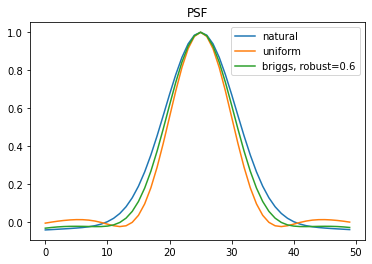

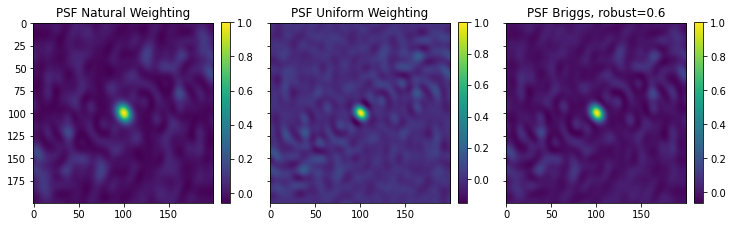

In [ ]:
from ngcasa.imaging import make_psf
import matplotlib.pylab as plt
import xarray

storage_parms['to_disk'] = True #bool, default: False

grid_parms = {}
grid_parms['chan_mode'] = 'continuum'
grid_parms['imsize'] =  [200,200]
grid_parms['cell'] = [0.04, 0.04]
grid_parms['oversampling'] = 100
grid_parms['support'] = 7
grid_parms['fft_padding'] =  1.2


storage_parms['append'] = False #'append' needs to be changed to false since an img.zarr file does not exist yet.
storage_parms['outfile'] = 'twhya_standard_gridder_lsrk_mfs.img.zarr' #Change outfile name to image file.

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_NAT'
grid_parms['image_name'] = 'PSF_NAT'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_NAT_PSF'
img_dataset = make_psf(vis_dataset,grid_parms,storage_parms)

storage_parms['append'] = True #Since storage_parms['outfile'] has been created we can now append the other psf files
grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_UNI'
grid_parms['image_name'] = 'PSF_UNI'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_UNI_PSF'
img_dataset = make_psf(vis_dataset,grid_parms,storage_parms)

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_BRG'
grid_parms['image_name'] = 'PSF_BRG'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_BRG_PSF'
img_dataset = make_psf(vis_dataset,grid_parms,storage_parms)

## Plot PSF images
plt.figure()
plt.plot(img_dataset.PSF_NAT[100,75:125,0,0],label='natural')
plt.plot(img_dataset.PSF_UNI[100,75:125,0,0],label='uniform')
plt.plot(img_dataset.PSF_BRG[100,75:125,0,0],label='briggs, robust='+str(imaging_weight_parms['robust']))
plt.legend()
plt.title('PSF')
plt.show()

fig0, ax0 = plt.subplots(1, 3, sharey=True,figsize=(12, 5))
im0 = ax0[0].imshow(img_dataset.PSF_NAT[:,:,0,0])
im1 = ax0[1].imshow(img_dataset.PSF_UNI[:,:,0,0])
im2 = ax0[2].imshow(img_dataset.PSF_BRG[:,:,0,0])
ax0[0].title.set_text('PSF Natural Weighting')
ax0[1].title.set_text('PSF Uniform Weighting')
ax0[2].title.set_text('PSF Briggs, robust='+str(imaging_weight_parms['robust']))
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
fig0.colorbar(im2, ax=ax0[2], fraction=0.046, pad=0.04)
plt.show()

## Make Dirty Images

To demonstrate an alternative usage mode the differently weighted dirty images will be combined into one graph and then executed in parallel (dask intelligently combines the graphs). 

[make_image documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/api/imaging.make_image.html)

######################### Start make_image #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default graph_name  to  make_image
##################### Created graph for make_image #####################
######################### Start make_image #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default graph_name  to  make_image
##################### Created graph for make_image #####################
######################### Start make_image #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default graph_name  to  make_image
##################### Created graph for make_image #####################


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.561386 to fit


Time to store and execute graph  three make_image parallel 13.654202699661255


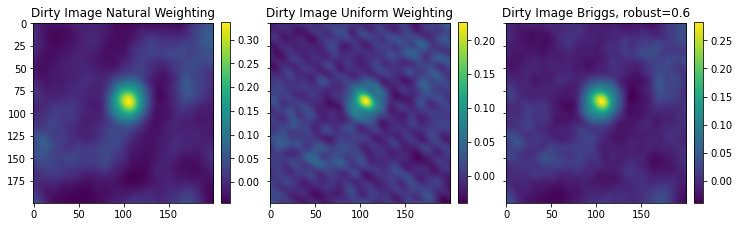

<xarray.Dataset>
Dimensions:             (chan: 1, d0: 200, d1: 200, pol: 1)
Coordinates:
  * chan                (chan) float64 3.726e+11
    chan_width          (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * d0                  (d0) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * d1                  (d1) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * pol                 (pol) int64 0
Data variables:
    DIRTY_IMAGE_BRG     (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarray>
    DIRTY_IMAGE_NAT     (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarray>
    DIRTY_IMAGE_UNI     (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarray>
    PSF_BRG             (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarray>
    PSF_NAT             (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarray>
    PSF_UNI             (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarray>
    SUM_WEIGHT_BRG      (chan, pol) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SUM_WEIGHT_BRG_PSF  (chan, pol) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SUM_WEIGHT_NAT      (chan, pol) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SUM_WEIGHT_NAT_PSF  (chan, pol) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SUM_WEIGHT_UNI      (chan, pol) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SUM_WEIGHT_UNI_PSF  (chan, pol) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes:
    make_psf_time:                   3.632297992706299
    three make_image parallel_time:  13.654202699661255

In [ ]:
from ngcasa.imaging import make_image
from cngi.dio import write_zarr
import dask

storage_parms['to_disk'] = False
grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_NAT'
grid_parms['image_name'] = 'DIRTY_IMAGE_NAT'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_NAT'
img_dataset_nat = make_image(vis_dataset,grid_parms,storage_parms)

dask.visualize(img_dataset_nat,filename='single_graph.png')

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_UNI'
grid_parms['image_name'] = 'DIRTY_IMAGE_UNI'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_UNI'
img_dataset_uni = make_image(vis_dataset,grid_parms,storage_parms)

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_BRG'
grid_parms['image_name'] = 'DIRTY_IMAGE_BRG'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_BRG'
img_dataset_brg = make_image(vis_dataset,grid_parms,storage_parms)

img_dataset['DIRTY_IMAGE_NAT'] = img_dataset_nat['DIRTY_IMAGE_NAT'] 
img_dataset['SUM_WEIGHT_NAT'] = img_dataset_nat['SUM_WEIGHT_NAT'] 
img_dataset['DIRTY_IMAGE_UNI'] = img_dataset_uni['DIRTY_IMAGE_UNI'] 
img_dataset['SUM_WEIGHT_UNI'] = img_dataset_uni['SUM_WEIGHT_UNI'] 
img_dataset['DIRTY_IMAGE_BRG'] = img_dataset_brg['DIRTY_IMAGE_BRG'] 
img_dataset['SUM_WEIGHT_BRG'] = img_dataset_brg['SUM_WEIGHT_BRG'] 

dask.visualize(img_dataset,filename='combined_graph.png')

img_dataset = write_zarr(img_dataset, outfile=storage_parms['outfile'], graph_name='three make_image parallel')

fig0, ax0 = plt.subplots(1, 3, sharey=True,figsize=(12, 5))
im0 = ax0[0].imshow(img_dataset.DIRTY_IMAGE_NAT[:,:,0,0])
im1 = ax0[1].imshow(img_dataset.DIRTY_IMAGE_UNI[:,:,0,0])
im2 = ax0[2].imshow(img_dataset.DIRTY_IMAGE_BRG[:,:,0,0])
ax0[0].title.set_text('Dirty Image Natural Weighting')
ax0[1].title.set_text('Dirty Image Uniform Weighting')
ax0[2].title.set_text('Dirty Image Briggs, robust='+str(imaging_weight_parms['robust']))
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
fig0.colorbar(im2, ax=ax0[2], fraction=0.046, pad=0.04)
plt.show()

img_dataset

## Dask Visualization

The Dask execution graph below shows how a continuum image with two chunks of visibility data is created. 

<div>
<img src=https://raw.githubusercontent.com/casangi/ngcasa/master/docs/prototypes/single_graph.png width="400">
</div>

The Dask execution graph below shows how all three images can be processed in parallel (Dask automatically combines the graphs for each image). The blocks on the right and left hand side, with no graphs, are the psf and psf sum of weight images that have already been saved to disk.

<div>
<img src=https://raw.githubusercontent.com/casangi/ngcasa/master/docs/prototypes/combined_graph.png >
</div>